# Validate Pulled Data for VAE vs Heston Comparison

This notebook validates that all pulled WRDS data is consistent and ready for:
1. **VAE Training** - Volatility surface data
2. **Heston Calibration** - Zero curves + forward prices

We need to ensure:
- Same date coverage across all datasets
- Compatible maturity grids (or identify interpolation needs)
- No critical missing values

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------
# CONFIG
# -------------------
TICKER = "AAPL"
START_DATE = "2016-01-01"
END_DATE = "2025-12-31"

RAW_DIR = Path("../../data/raw/ivydb")

# File paths
VS_PATH = RAW_DIR / "vol_surface" / f"{TICKER}_vsurfd_{START_DATE}_{END_DATE}.csv.gz"
PX_PATH = RAW_DIR / "security_price" / f"{TICKER}_underlying_{START_DATE}_{END_DATE}.csv.gz"
ZC_PATH = RAW_DIR / "zero_curve" / f"zero_curve_{START_DATE}_{END_DATE}.csv.gz"
STDOP_PATH = RAW_DIR / "std_option_price" / f"{TICKER}_stdopd_{START_DATE}_{END_DATE}.csv.gz"

print("Data files:")
for name, path in [("Vol Surface", VS_PATH), ("Underlying Px", PX_PATH), 
                    ("Zero Curve", ZC_PATH), ("Std Option", STDOP_PATH)]:
    exists = "✓" if path.exists() else "✗ MISSING"
    print(f"  {exists} {name}: {path.name}")

Data files:
  ✓ Vol Surface: AAPL_vsurfd_2016-01-01_2025-12-31.csv.gz
  ✓ Underlying Px: AAPL_underlying_2016-01-01_2025-12-31.csv.gz
  ✓ Zero Curve: zero_curve_2016-01-01_2025-12-31.csv.gz
  ✓ Std Option: AAPL_stdopd_2016-01-01_2025-12-31.csv.gz


## 1. Load All Datasets

In [2]:
# Load datasets
vs = pd.read_csv(VS_PATH, parse_dates=["date"])
px = pd.read_csv(PX_PATH, parse_dates=["date"])
zc = pd.read_csv(ZC_PATH, parse_dates=["date"])
stdop = pd.read_csv(STDOP_PATH, parse_dates=["date"])

print("Dataset shapes:")
print(f"  Volatility Surface: {vs.shape}")
print(f"  Underlying Prices:  {px.shape}")
print(f"  Zero Curve:         {zc.shape}")
print(f"  Std Option Prices:  {stdop.shape}")

Dataset shapes:
  Volatility Surface: (908446, 9)
  Underlying Prices:  (2429, 11)
  Zero Curve:         (77707, 3)
  Std Option Prices:  (53438, 8)


In [3]:
# Quick peek at each dataset
print("=" * 60)
print("VOLATILITY SURFACE (vsurfd)")
print("=" * 60)
print(f"Columns: {list(vs.columns)}")
display(vs.head(3))

print("\n" + "=" * 60)
print("ZERO CURVE (zerocd)")
print("=" * 60)
print(f"Columns: {list(zc.columns)}")
display(zc.head(3))

print("\n" + "=" * 60)
print("STD OPTION PRICES (stdopd)")
print("=" * 60)
print(f"Columns: {list(stdop.columns)}")
display(stdop.head(3))

VOLATILITY SURFACE (vsurfd)
Columns: ['secid', 'date', 'days', 'delta', 'cp_flag', 'impl_volatility', 'impl_strike', 'impl_premium', 'dispersion']


,secid,date,days,delta,cp_flag,impl_volatility,impl_strike,impl_premium,dispersion
0,101594.0,2016-01-04,10,-0.90,P,0.351577,113.5996,8.665669,0.214947
1,101594.0,2016-01-04,10,-0.85,P,0.296881,110.8722,6.048973,0.144321
2,101594.0,2016-01-04,10,-0.80,P,0.267112,109.3283,4.620924,0.069316



ZERO CURVE (zerocd)
Columns: ['date', 'days', 'rate']


,date,days,rate
0,2016-01-04,7.0,0.392860
1,2016-01-04,16.0,0.406151
2,2016-01-04,44.0,0.542785



STD OPTION PRICES (stdopd)
Columns: ['secid', 'date', 'days', 'cp_flag', 'forward_price', 'strike_price', 'impl_volatility', 'delta']


,secid,date,days,cp_flag,forward_price,strike_price,impl_volatility,delta
0,101594.0,2016-01-04,10.0,C,105.211513,105.211513,0.276650,0.511500
1,101594.0,2016-01-04,10.0,P,105.211513,105.211513,0.278642,-0.490105
2,101594.0,2016-01-04,30.0,C,105.238364,105.238364,0.336750,0.519545


## 2. Date Coverage Analysis

In [4]:
# Extract unique dates from each dataset
vs_dates = set(vs["date"].dt.date)
px_dates = set(px["date"].dt.date)
zc_dates = set(zc["date"].dt.date)
stdop_dates = set(stdop["date"].dt.date)

print("Date Coverage Summary:")
print(f"  Vol Surface:  {len(vs_dates):,} unique dates | {min(vs_dates)} to {max(vs_dates)}")
print(f"  Underlying:   {len(px_dates):,} unique dates | {min(px_dates)} to {max(px_dates)}")
print(f"  Zero Curve:   {len(zc_dates):,} unique dates | {min(zc_dates)} to {max(zc_dates)}")
print(f"  Std Option:   {len(stdop_dates):,} unique dates | {min(stdop_dates)} to {max(stdop_dates)}")

Date Coverage Summary:
  Vol Surface:  2,429 unique dates | 2016-01-04 to 2025-08-29
  Underlying:   2,429 unique dates | 2016-01-04 to 2025-08-29
  Zero Curve:   2,429 unique dates | 2016-01-04 to 2025-08-29
  Std Option:   2,429 unique dates | 2016-01-04 to 2025-08-29


In [5]:
# Find intersection of all dates
common_dates = vs_dates & px_dates & zc_dates & stdop_dates
print(f"\nCommon dates across ALL datasets: {len(common_dates):,}")
print(f"  Range: {min(common_dates)} to {max(common_dates)}")

# Check what's missing from each
print("\nDates present in Vol Surface but missing from:")
print(f"  Underlying:  {len(vs_dates - px_dates):,}")
print(f"  Zero Curve:  {len(vs_dates - zc_dates):,}")
print(f"  Std Option:  {len(vs_dates - stdop_dates):,}")

# The key constraint: we need vs_dates to be a subset of the others for Heston
vs_minus_common = vs_dates - common_dates
print(f"\n⚠️  Vol surface dates NOT in common set: {len(vs_minus_common):,}")
if vs_minus_common:
    print(f"  Sample: {sorted(vs_minus_common)[:5]}...")


Common dates across ALL datasets: 2,429
  Range: 2016-01-04 to 2025-08-29

Dates present in Vol Surface but missing from:
  Underlying:  0
  Zero Curve:  0
  Std Option:  0

⚠️  Vol surface dates NOT in common set: 0


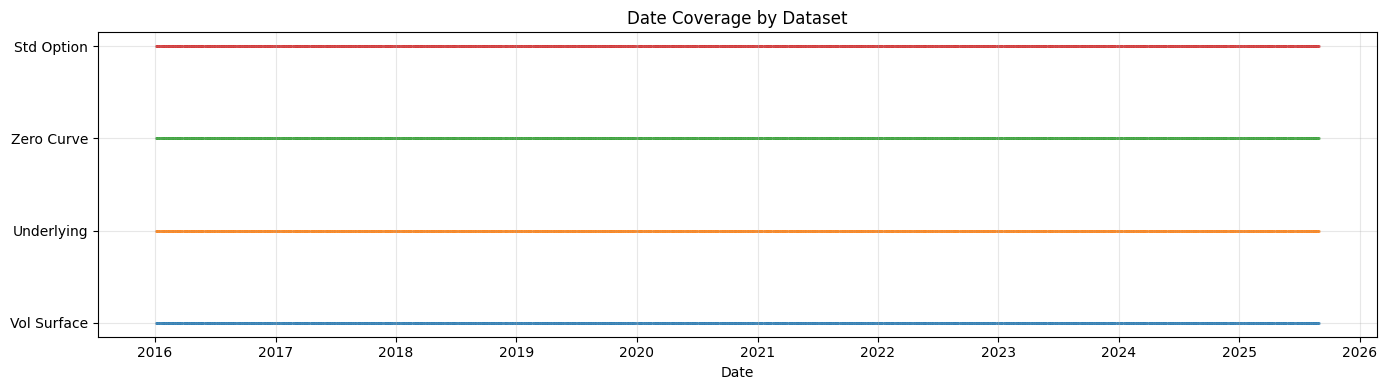

In [6]:
# Visualize date coverage
fig, ax = plt.subplots(figsize=(14, 4))

datasets = {
    "Vol Surface": vs_dates,
    "Underlying": px_dates,
    "Zero Curve": zc_dates,
    "Std Option": stdop_dates,
}

for i, (name, dates) in enumerate(datasets.items()):
    dates_sorted = sorted(dates)
    ax.scatter(dates_sorted, [i] * len(dates_sorted), s=1, alpha=0.5, label=name)

ax.set_yticks(range(len(datasets)))
ax.set_yticklabels(list(datasets.keys()))
ax.set_xlabel("Date")
ax.set_title("Date Coverage by Dataset")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Maturity (Days) Grid Analysis

Critical question: Do the maturities in `vsurfd` match those in `zerocd` and `stdopd`?

In [7]:
# Unique days in each dataset
vs_days = sorted(vs["days"].unique())
zc_days = sorted(zc["days"].unique())
stdop_days = sorted(stdop["days"].unique())

print("Maturity (days) Grid Summary:")
print(f"\nVol Surface ({len(vs_days)} unique):")
print(f"  {vs_days}")

print(f"\nZero Curve ({len(zc_days)} unique):")
print(f"  {zc_days[:20]}{'...' if len(zc_days) > 20 else ''}")

print(f"\nStd Option ({len(stdop_days)} unique):")
print(f"  {stdop_days}")

Maturity (days) Grid Summary:

Vol Surface (11 unique):
  [np.int64(10), np.int64(30), np.int64(60), np.int64(91), np.int64(122), np.int64(152), np.int64(182), np.int64(273), np.int64(365), np.int64(547), np.int64(730)]

Zero Curve (3664 unique):
  [np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0)]...

Std Option (11 unique):
  [np.float64(10.0), np.float64(30.0), np.float64(60.0), np.float64(91.0), np.float64(122.0), np.float64(152.0), np.float64(182.0), np.float64(273.0), np.float64(365.0), np.float64(547.0), np.float64(730.0)]


In [8]:
# Check overlap
vs_days_set = set(vs_days)
zc_days_set = set(zc_days)
stdop_days_set = set(stdop_days)

print("Maturity Grid Alignment:")
print(f"\nVol Surface days in Zero Curve:  {len(vs_days_set & zc_days_set)}/{len(vs_days_set)}")
print(f"Vol Surface days in Std Option:  {len(vs_days_set & stdop_days_set)}/{len(vs_days_set)}")

vs_not_in_zc = vs_days_set - zc_days_set
vs_not_in_stdop = vs_days_set - stdop_days_set

if vs_not_in_zc:
    print(f"\n⚠️  Vol Surface days NOT in Zero Curve: {sorted(vs_not_in_zc)}")
    print("   → Will need to INTERPOLATE zero rates for these maturities")
else:
    print("\n✓ All Vol Surface maturities found in Zero Curve")

if vs_not_in_stdop:
    print(f"\n⚠️  Vol Surface days NOT in Std Option: {sorted(vs_not_in_stdop)}")
    print("   → Will need to INTERPOLATE forward prices for these maturities")
else:
    print("\n✓ All Vol Surface maturities found in Std Option")

Maturity Grid Alignment:

Vol Surface days in Zero Curve:  11/11
Vol Surface days in Std Option:  11/11

✓ All Vol Surface maturities found in Zero Curve

✓ All Vol Surface maturities found in Std Option


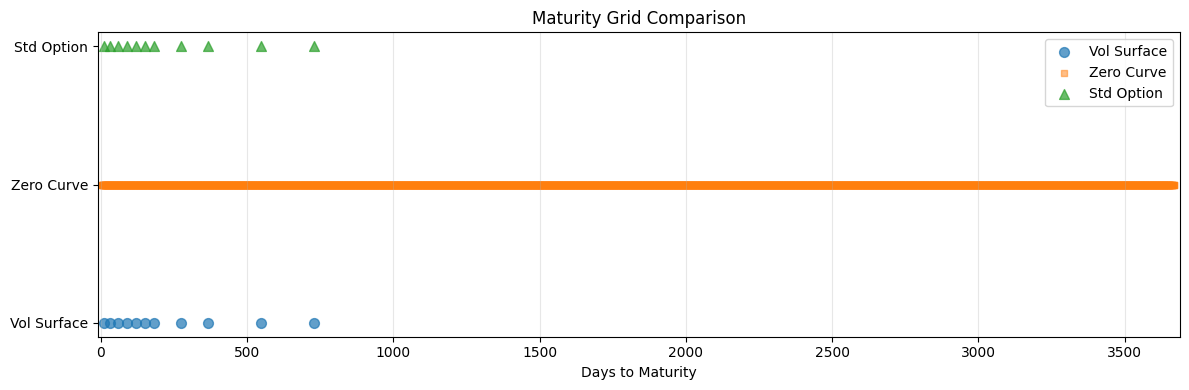

In [9]:
# Visualize maturity grids
fig, ax = plt.subplots(figsize=(12, 4))

y_pos = {"Vol Surface": 0, "Zero Curve": 1, "Std Option": 2}

ax.scatter(vs_days, [0] * len(vs_days), s=50, marker='o', label="Vol Surface", alpha=0.7)
ax.scatter(zc_days, [1] * len(zc_days), s=20, marker='s', label="Zero Curve", alpha=0.5)
ax.scatter(stdop_days, [2] * len(stdop_days), s=50, marker='^', label="Std Option", alpha=0.7)

ax.set_yticks([0, 1, 2])
ax.set_yticklabels(["Vol Surface", "Zero Curve", "Std Option"])
ax.set_xlabel("Days to Maturity")
ax.set_title("Maturity Grid Comparison")
ax.set_xlim(-10, max(max(vs_days), max(zc_days), max(stdop_days)) + 20)
ax.grid(True, alpha=0.3, axis='x')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

## 4. Delta Grid Analysis (Vol Surface)

In [10]:
# Unique deltas and cp_flag combinations
vs_deltas = sorted(vs["delta"].unique())
vs_cp = sorted(vs["cp_flag"].unique())

print("Vol Surface Delta Grid:")
print(f"  Deltas ({len(vs_deltas)}): {vs_deltas}")
print(f"  CP flags: {vs_cp}")

# Expected grid size per date
expected_grid_size = len(vs_days) * len(vs_deltas) * len(vs_cp)
print(f"\nExpected full grid per date: {len(vs_days)} days × {len(vs_deltas)} deltas × {len(vs_cp)} cp = {expected_grid_size}")

Vol Surface Delta Grid:
  Deltas (34): [np.float64(-0.9), np.float64(-0.85), np.float64(-0.8), np.float64(-0.75), np.float64(-0.7), np.float64(-0.65), np.float64(-0.6), np.float64(-0.55), np.float64(-0.5), np.float64(-0.45), np.float64(-0.4), np.float64(-0.35), np.float64(-0.3), np.float64(-0.25), np.float64(-0.2), np.float64(-0.15), np.float64(-0.1), np.float64(0.1), np.float64(0.15), np.float64(0.2), np.float64(0.25), np.float64(0.3), np.float64(0.35), np.float64(0.4), np.float64(0.45), np.float64(0.5), np.float64(0.55), np.float64(0.6), np.float64(0.65), np.float64(0.7), np.float64(0.75), np.float64(0.8), np.float64(0.85), np.float64(0.9)]
  CP flags: ['C', 'P']

Expected full grid per date: 11 days × 34 deltas × 2 cp = 748


In [11]:
# Check grid completeness per date
grid_size_per_date = vs.groupby("date").size()

print("Grid size per date:")
print(grid_size_per_date.describe())

full_grid_dates = (grid_size_per_date == expected_grid_size).sum()
print(f"\nDates with full grid: {full_grid_dates}/{len(grid_size_per_date)} ({100*full_grid_dates/len(grid_size_per_date):.1f}%)")

Grid size per date:
count    2429.0
mean      374.0
std         0.0
min       374.0
25%       374.0
50%       374.0
75%       374.0
max       374.0
dtype: float64

Dates with full grid: 0/2429 (0.0%)


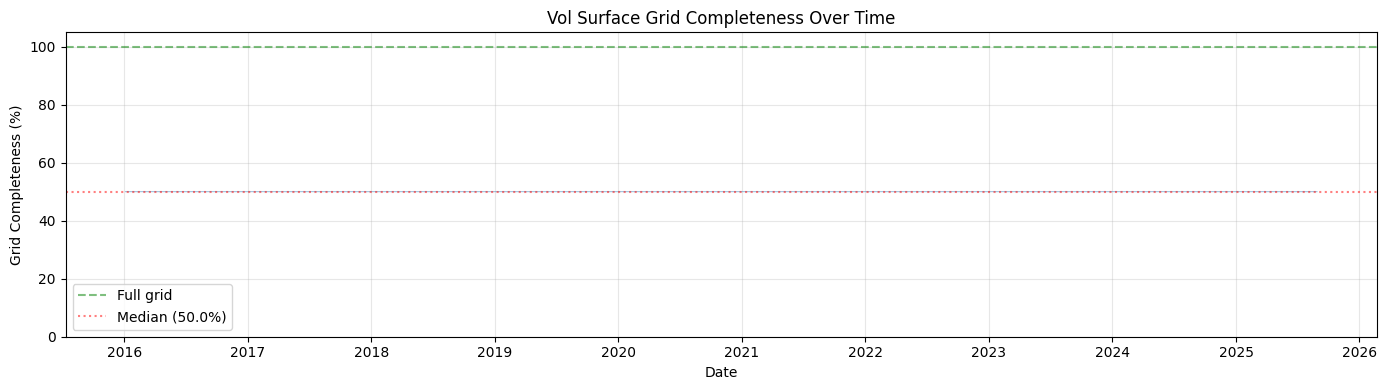

In [12]:
# Visualize grid completeness over time
fig, ax = plt.subplots(figsize=(14, 4))

completeness = (grid_size_per_date / expected_grid_size * 100).reset_index()
completeness.columns = ["date", "pct_complete"]

ax.plot(completeness["date"], completeness["pct_complete"], linewidth=0.5, alpha=0.7)
ax.axhline(100, color='g', linestyle='--', alpha=0.5, label='Full grid')
ax.axhline(completeness["pct_complete"].median(), color='r', linestyle=':', alpha=0.5, 
           label=f'Median ({completeness["pct_complete"].median():.1f}%)')

ax.set_xlabel("Date")
ax.set_ylabel("Grid Completeness (%)")
ax.set_title("Vol Surface Grid Completeness Over Time")
ax.set_ylim(0, 105)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Missing Values Analysis

In [13]:
# Check for missing/sentinel values in critical columns
print("Missing Values Summary:")
print("\nVol Surface:")
print(f"  impl_volatility NaN:       {vs['impl_volatility'].isna().sum():,}")
print(f"  impl_volatility == -99.99: {(vs['impl_volatility'] == -99.99).sum():,}")
print(f"  dispersion == -99.99:      {(vs['dispersion'] == -99.99).sum():,}")

print("\nZero Curve:")
print(f"  rate NaN:  {zc['rate'].isna().sum():,}")
print(f"  rate <= 0: {(zc['rate'] <= 0).sum():,}")

print("\nStd Option:")
print(f"  forward_price NaN:  {stdop['forward_price'].isna().sum():,}")
print(f"  forward_price <= 0: {(stdop['forward_price'] <= 0).sum():,}")

Missing Values Summary:

Vol Surface:
  impl_volatility NaN:       0
  impl_volatility == -99.99: 0
  dispersion == -99.99:      0

Zero Curve:
  rate NaN:  0
  rate <= 0: 0

Std Option:
  forward_price NaN:  0
  forward_price <= 0: 0


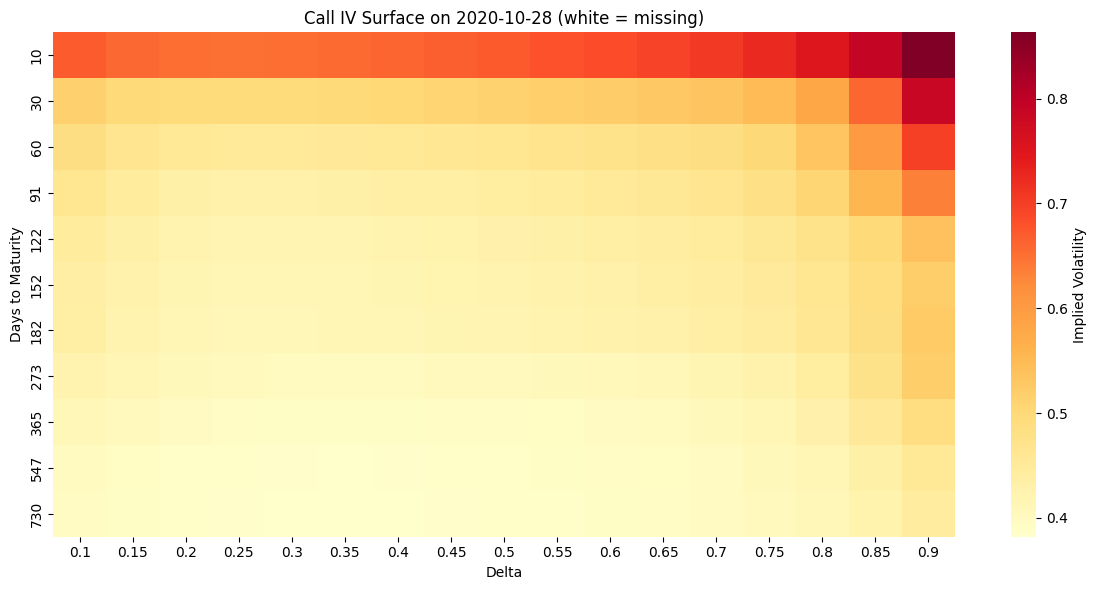

In [14]:
# Heatmap of IV missingness by (days, delta) for a sample date
sample_date = vs["date"].iloc[len(vs)//2]
sample = vs[vs["date"] == sample_date].copy()

# Create pivot for calls
calls = sample[sample["cp_flag"] == "C"].pivot_table(
    index="days", columns="delta", values="impl_volatility", aggfunc="first"
)

fig, ax = plt.subplots(figsize=(12, 6))
mask = calls.isna() | (calls == -99.99)
sns.heatmap(calls.where(~mask), annot=False, cmap="YlOrRd", ax=ax,
            cbar_kws={"label": "Implied Volatility"})
ax.set_title(f"Call IV Surface on {str(sample_date)[:10]} (white = missing)")
ax.set_xlabel("Delta")
ax.set_ylabel("Days to Maturity")
plt.tight_layout()
plt.show()

## 6. Forward Price / Carry Rate Analysis

For Heston calibration, we need the carry rate $q(T)$ derived from:
$$q(T) = r(T) - \frac{1}{T} \ln\left(\frac{F(T)}{S_0}\right)$$

In [15]:
# Check if we can compute q(T) for common dates
# Need: spot price, forward price, risk-free rate, all for the same (date, days)

# Get spot prices
px_spot = px[["date", "close"]].copy()
px_spot.columns = ["date", "spot"]

# Get forward prices (one per date/days - should be same for C and P)
fwd = stdop.groupby(["date", "days"])["forward_price"].first().reset_index()

# Get rates
rates = zc[["date", "days", "rate"]].copy()

print(f"Spot prices: {len(px_spot):,} dates")
print(f"Forward prices: {len(fwd):,} (date, days) pairs")
print(f"Rates: {len(rates):,} (date, days) pairs")

Spot prices: 2,429 dates
Forward prices: 26,719 (date, days) pairs
Rates: 77,707 (date, days) pairs


In [16]:
# Merge to check coverage
merged = fwd.merge(rates, on=["date", "days"], how="inner")
merged = merged.merge(px_spot, on="date", how="inner")

print(f"Merged (date, days) with spot, forward, rate: {len(merged):,} rows")
print(f"Unique dates: {merged['date'].nunique():,}")
print(f"Unique days: {sorted(merged['days'].unique())}")

Merged (date, days) with spot, forward, rate: 10,781 rows
Unique dates: 1,290
Unique days: [np.float64(10.0), np.float64(30.0), np.float64(60.0), np.float64(91.0), np.float64(122.0), np.float64(152.0), np.float64(182.0), np.float64(273.0), np.float64(365.0), np.float64(547.0), np.float64(730.0)]


In [17]:
# Compute implied carry rate q(T)
merged["T"] = merged["days"] / 365.0
merged["q"] = merged["rate"] - (1 / merged["T"]) * np.log(merged["forward_price"] / merged["spot"])

print("Implied Carry Rate q(T) Summary:")
print(merged["q"].describe())

# Check for anomalies
anomalies = merged[(merged["q"] < -0.1) | (merged["q"] > 0.2)]
print(f"\nAnomalous q values (< -10% or > 20%): {len(anomalies):,}")

Implied Carry Rate q(T) Summary:
count    10781.000000
mean         4.003190
std          1.572375
min          0.068561
25%          3.464115
50%          4.590198
75%          5.170720
max          5.741046
Name: q, dtype: float64

Anomalous q values (< -10% or > 20%): 10,660


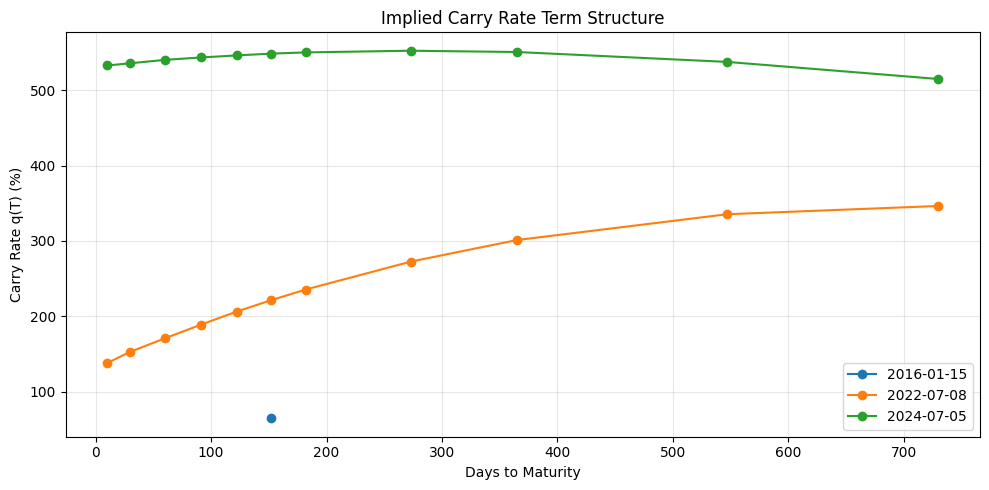

In [18]:
# Plot q(T) term structure for sample dates
sample_dates = merged["date"].drop_duplicates().iloc[::500].head(5).tolist()

fig, ax = plt.subplots(figsize=(10, 5))
for d in sample_dates:
    curve = merged[merged["date"] == d].sort_values("days")
    ax.plot(curve["days"], curve["q"] * 100, 'o-', label=str(d)[:10], markersize=6)

ax.set_xlabel("Days to Maturity")
ax.set_ylabel("Carry Rate q(T) (%)")
ax.set_title("Implied Carry Rate Term Structure")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Summary & Recommendations

In [19]:
print("=" * 70)
print("DATA VALIDATION SUMMARY")
print("=" * 70)

print(f"\n📅 DATE COVERAGE:")
print(f"   Vol Surface dates:        {len(vs_dates):,}")
print(f"   Common dates (all data):  {len(common_dates):,}")
pct_common = 100 * len(common_dates) / len(vs_dates)
status = "✓" if pct_common > 95 else "⚠️"
print(f"   {status} Coverage: {pct_common:.1f}%")

print(f"\n📊 MATURITY GRID:")
print(f"   Vol Surface maturities: {vs_days}")
print(f"   Std Option maturities:  {stdop_days}")
if vs_not_in_stdop:
    print(f"   ⚠️  Need interpolation for: {sorted(vs_not_in_stdop)}")
else:
    print(f"   ✓ All maturities aligned")

print(f"\n🔢 GRID COMPLETENESS:")
print(f"   Expected grid size: {expected_grid_size}")
print(f"   Median actual:      {grid_size_per_date.median():.0f}")
print(f"   Full grid dates:    {full_grid_dates}/{len(grid_size_per_date)}")

print(f"\n💰 HESTON INPUTS:")
print(f"   Forward prices available: {len(merged):,} (date, T) pairs")
print(f"   Carry rate q range: [{merged['q'].min():.4f}, {merged['q'].max():.4f}]")

print("\n" + "=" * 70)
print("RECOMMENDATIONS:")
print("=" * 70)

DATA VALIDATION SUMMARY

📅 DATE COVERAGE:
   Vol Surface dates:        2,429
   Common dates (all data):  2,429
   ✓ Coverage: 100.0%

📊 MATURITY GRID:
   Vol Surface maturities: [np.int64(10), np.int64(30), np.int64(60), np.int64(91), np.int64(122), np.int64(152), np.int64(182), np.int64(273), np.int64(365), np.int64(547), np.int64(730)]
   Std Option maturities:  [np.float64(10.0), np.float64(30.0), np.float64(60.0), np.float64(91.0), np.float64(122.0), np.float64(152.0), np.float64(182.0), np.float64(273.0), np.float64(365.0), np.float64(547.0), np.float64(730.0)]
   ✓ All maturities aligned

🔢 GRID COMPLETENESS:
   Expected grid size: 748
   Median actual:      374
   Full grid dates:    0/2429

💰 HESTON INPUTS:
   Forward prices available: 10,781 (date, T) pairs
   Carry rate q range: [0.0686, 5.7410]

RECOMMENDATIONS:


In [20]:
# Generate specific recommendations
recommendations = []

if pct_common < 100:
    missing_pct = 100 - pct_common
    recommendations.append(
        f"DATES: {missing_pct:.1f}% of vol surface dates lack complete Heston inputs. "
        f"Option 1: Filter to common dates only. Option 2: Forward-fill missing rates/forwards."
    )

if vs_not_in_stdop:
    recommendations.append(
        f"MATURITIES: Maturities {sorted(vs_not_in_stdop)} are in vol surface but not in stdopd. "
        f"Must interpolate forward prices for these tenors."
    )

if vs_not_in_zc:
    recommendations.append(
        f"ZERO CURVE: Maturities {sorted(vs_not_in_zc)} need rate interpolation."
    )

if grid_size_per_date.median() < expected_grid_size * 0.9:
    recommendations.append(
        f"GRID SPARSITY: Median grid fill is {100*grid_size_per_date.median()/expected_grid_size:.0f}%. "
        f"VAE must handle missing values (masking) during training."
    )

if anomalies is not None and len(anomalies) > 0:
    recommendations.append(
        f"CARRY RATES: {len(anomalies)} anomalous q(T) values detected. "
        f"Consider filtering or capping extreme values."
    )

if not recommendations:
    recommendations.append("✓ Data looks well-aligned! Ready for processing.")

for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. {rec}")


1. GRID SPARSITY: Median grid fill is 50%. VAE must handle missing values (masking) during training.

2. CARRY RATES: 10660 anomalous q(T) values detected. Consider filtering or capping extreme values.


In [21]:
# Save common dates list for downstream use
common_dates_df = pd.DataFrame({"date": sorted(common_dates)})
common_dates_path = RAW_DIR.parent / "processed" / "common_dates.csv"
common_dates_path.parent.mkdir(parents=True, exist_ok=True)
common_dates_df.to_csv(common_dates_path, index=False)
print(f"Saved {len(common_dates_df)} common dates to: {common_dates_path}")

Saved 2429 common dates to: ..\..\data\raw\processed\common_dates.csv
